In [1]:
import json
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
with open('./data/train.json', 'r') as fp:
    data = json.load(fp)

How many documents do not have any other label than 'O'

In [3]:
total_empty_docs = 0
all_info_docs = []

for idx, elem in tqdm(enumerate(data)):
    info_doc = sum([1 if l != 'O' else 0 for l in elem['labels']])
    if not info_doc:
        total_empty_docs += 1
        continue
    all_info_docs.append(idx)

print(f'Total docs: {len(data)}\n'
    f'Docs without any other label than "O": {total_empty_docs}\n'
    f'% of docs with no othe label than "O": {100*total_empty_docs/len(data)}'
)

6807it [00:00, 90890.25it/s]

Total docs: 6807
Docs without any other label than "O": 5862
% of docs with no othe label than "O": 86.11723226090788


What is the distribution of number of tokens in docs with have label other than 'O'

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 945/945 [00:00<00:00, 2446677.33it/s]


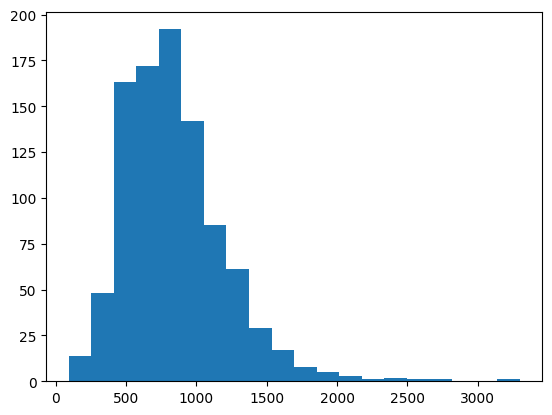

1029.0 1462.5999999999988 1991.8799999999987


In [4]:
token_lengths = []

for idx in tqdm(all_info_docs):
    token_lengths.append(
        len(data[idx]['tokens'])
    )

token_lengths = np.array(token_lengths)

plt.hist(token_lengths, 20)
plt.show()

print(np.percentile(token_lengths, 75), np.percentile(token_lengths, 95), np.percentile(token_lengths, 99))

What is the distribution of different labels

In [5]:
from data_utils import label2id

In [6]:
label_counts = dict.fromkeys(label2id.keys(), 0)

for idx in tqdm(range(0, len(data))):
    for l in data[idx]['labels']: label_counts[l] += 1

print(json.dumps(label_counts, indent=4))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6807/6807 [00:00<00:00, 23803.32it/s]

{
    "O": 4989794,
    "B-NAME_STUDENT": 1365,
    "B-EMAIL": 39,
    "B-USERNAME": 6,
    "B-ID_NUM": 78,
    "B-PHONE_NUM": 6,
    "B-URL_PERSONAL": 110,
    "B-STREET_ADDRESS": 2,
    "I-NAME_STUDENT": 1096,
    "I-EMAIL": 0,
    "I-USERNAME": 0,
    "I-ID_NUM": 1,
    "I-PHONE_NUM": 15,
    "I-URL_PERSONAL": 1,
    "I-STREET_ADDRESS": 20
}


Where are the different labels located?

In [7]:
label_posix = dict.fromkeys(label2id.keys())

for idx in tqdm(all_info_docs):
    for pos, l in enumerate(data[idx]['labels']):
        if l == 'O':
            continue

        temp = label_posix.get(l) if label_posix.get(l) else []
        temp.append(pos)
        label_posix.update({l: temp})

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 945/945 [00:00<00:00, 23139.27it/s]


Error for O len() of unsized object


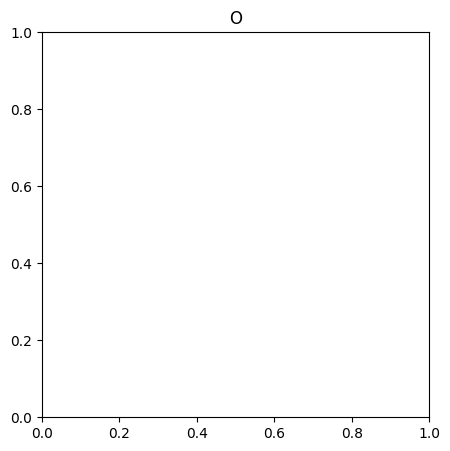

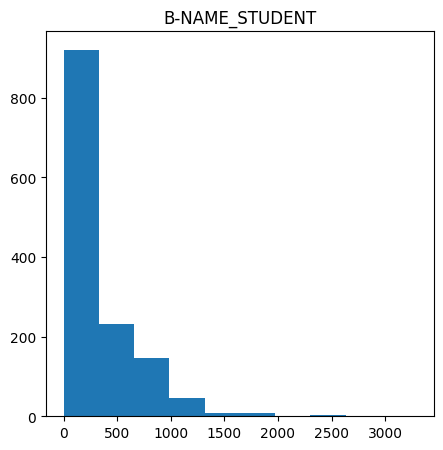

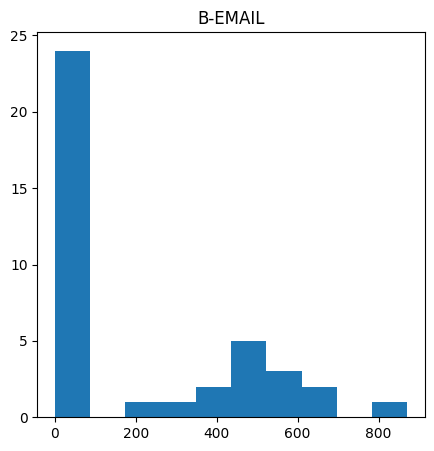

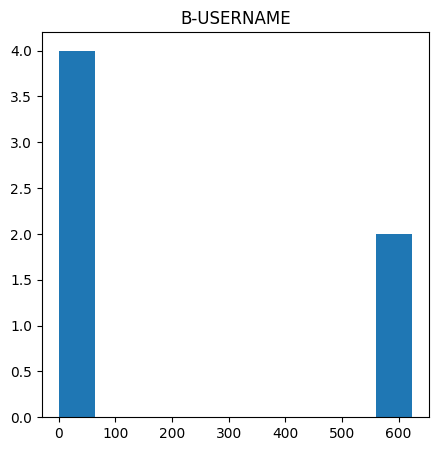

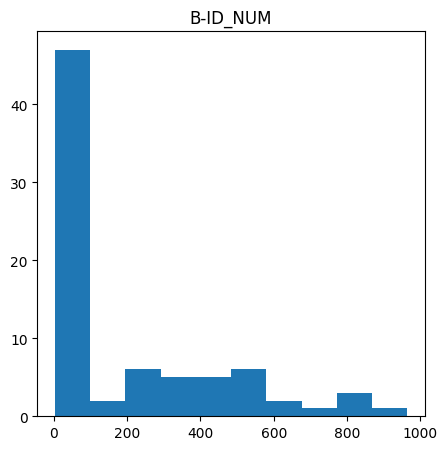

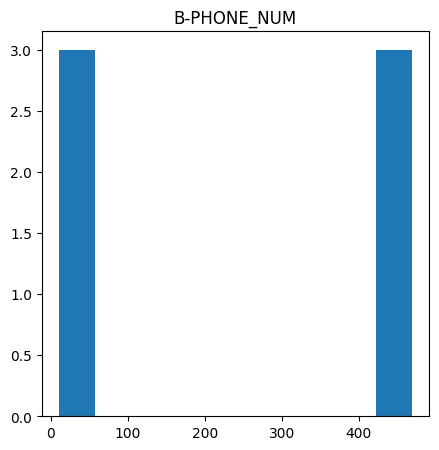

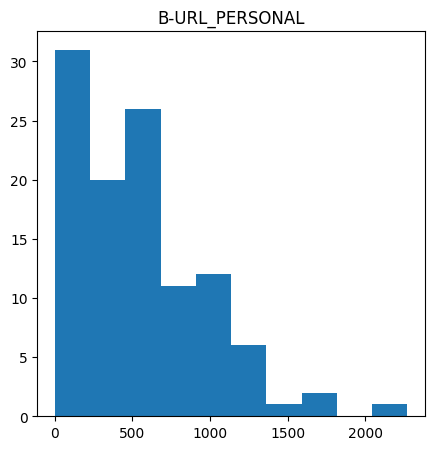

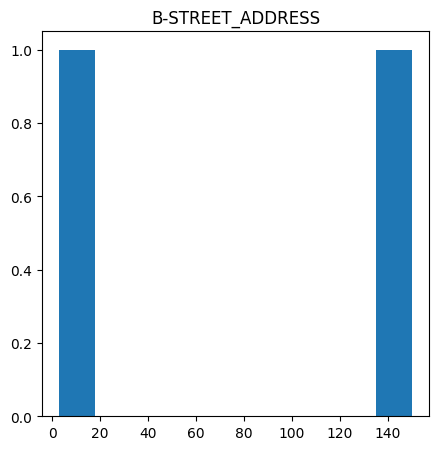

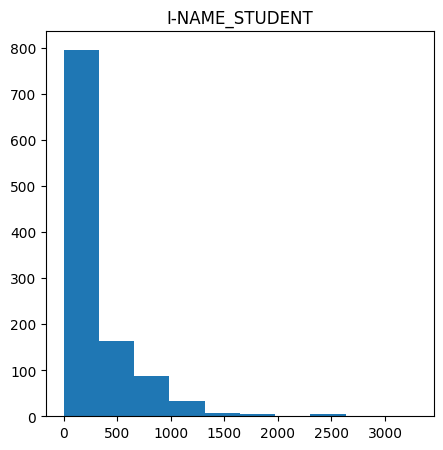

Error for I-EMAIL len() of unsized object
Error for I-USERNAME len() of unsized object


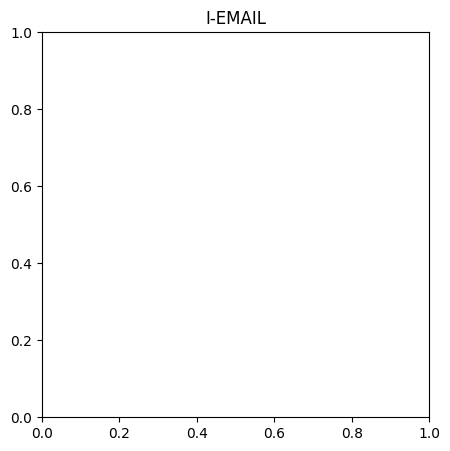

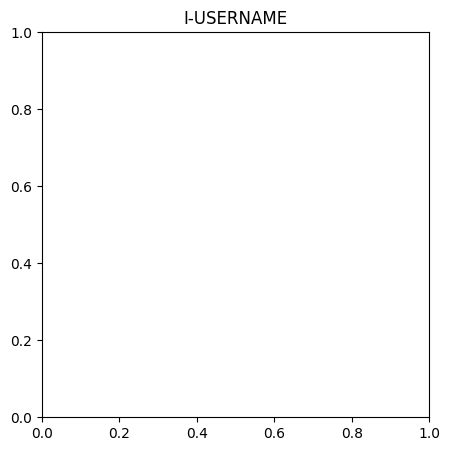

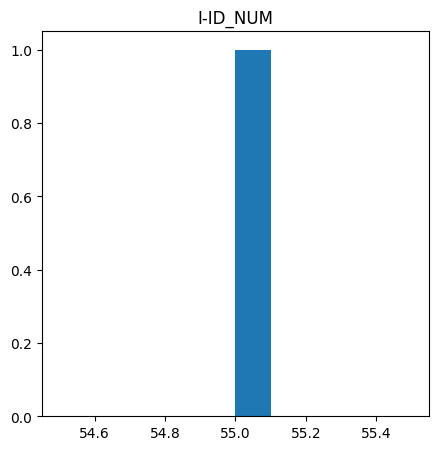

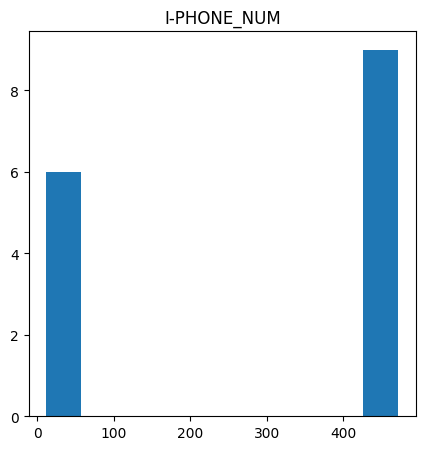

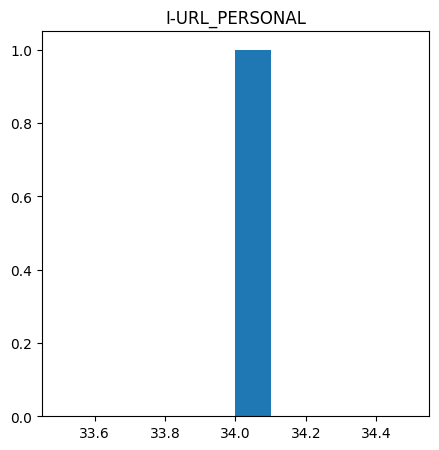

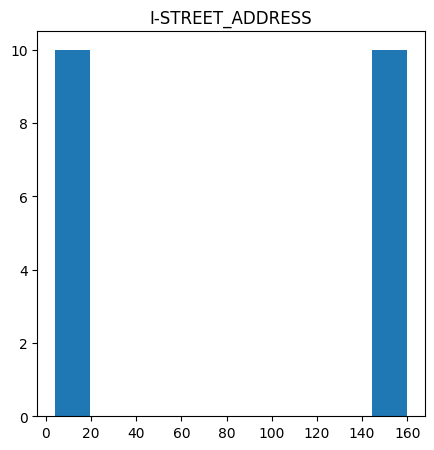

In [8]:
for k, v in label_posix.items():
    try:
        plt.figure(figsize=(5, 5))
        plt.title(k)
        temp = np.array(v)
        plt.hist(temp)
        plt.show()
    except Exception as err:
        print(f'Error for {k} {err}')

Observations
- 85%+ documents do not have any other label than O. We can sample from them, but unlikely to help a pretrained NER model
- Most of the documents which have labels, have # of words < 2k tokens, so a model that can take 2k tokens would work well
- Token position in the document is high only for name and URL
- Name has the only relevant amount of data, others are severly limited in data

Actions
1. Filter out documents that dont have any other label
2. Use a model with large context len
3. External data + data augmentation